In [1]:
#Colab setting
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/DSAIL')

import os
os.chdir('/content/drive/My Drive/DSAIL')

Mounted at /content/drive


In [80]:
# Data U1.base로 train, u1.test로 test data만들기
# U.data는 현재 (["user_id", "movie_id", "rating", "timestamp"])로 구성
import pandas as pd
import numpy as np

file_path = "ml-100k/u1.base"
columns = ["user_id", "movie_id", "rating", "timestamp"]
train_data = pd.read_csv(file_path, sep='\t', names=columns)

max_user_idx = train_data['user_id'].max()
max_movie_idx = train_data['movie_id'].max()

user_movie_matrix = np.zeros((max_user_idx, max_movie_idx))

for _, row in train_data.iterrows():
    user_movie_matrix[row['user_id']-1, row['movie_id']-1] = row['rating']

train = user_movie_matrix

file_path = "ml-100k/u1.test"
columns = ["user_id", "movie_id", "rating", "timestamp"]
test_data = pd.read_csv(file_path, sep='\t', names=columns)

max_user_idx_test = test_data['user_id'].max()
max_movie_idx_test = test_data['movie_id'].max()

user_movie_matrix_test = np.zeros((max_user_idx_test, max_movie_idx_test))
for _, row in test_data.iterrows():
    user_movie_matrix_test[row['user_id']-1, row['movie_id']-1] = row['rating']

test = user_movie_matrix_test

np.save("continous_train.npy", user_movie_matrix)
np.save("continous_test.npy", user_movie_matrix_test)
# # GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print("device", device)


In [3]:
# 필요한 함수들
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [78]:
user_movie_matrix.shape

(943, 1682)

In [79]:
user_movie_matrix_test.shape

(462, 1591)

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

class BPR():
  def __init__(self, train_R, test_R, d=16, lamb = 0.01, learning_rate=1e-3, epochs= 100):
    '''
    BPR_MF version
    gradient descent 직접 업데이트하는 방식
    '''
    self.num_user, self.num_item = train_R.shape
    self.test_n, self.test_m = test_R.shape

    self.latent_dimension = d

    # implicit하게 변환
    self.train_R = (train_R > 0).astype(float)
    self.test_R = (test_R > 0).astype(float)

    self.lr = learning_rate
    self.epoch = epochs
    self.lamb = lamb

    # torch로 짜면 loss하고 loss.backward()로 감
    # self.W = nn.Parameter(torch.empty(self.num_user, self.latent_dimension))
    # self.H = nn.Parameter(torch.empty(self.num_item, self.latent_dimension))

    # 직접 gradient 각각 update
    self.W = np.random.standard_normal((self.num_user, self.latent_dimension)) # (N, d)
    self.H = np.random.standard_normal((self.num_item, self.latent_dimension)) # (m, d)

    self.pos_items_dict = {user: np.where(self.train_R[user, :] > 0)[0] for user in range(self.num_user)}
    self.neg_items_dict = {user: np.where(self.train_R[user, :] == 0)[0] for user in range(self.num_user)}

  # sigmoid항 X dxui/dtheta
  # 얘가 sigmoid항 계산용
  def gradient_sigmoid(self, x):
    return sigmoid(x) * np.exp(-x)

  # dXhat/dtheta
  def gradient(self, u, i, j):
    xuij = self.get_xuij(u, i, j)
    sigma_term = self.gradient_sigmoid(xuij)

    dWu = -sigma_term * (self.H[i, :] - self.H[j, :]) - self.lamb * self.W[u, :] # (d, 1)
    dHi = -sigma_term * self.W[u, :] - self.lamb * self.H[i, :]
    dHj = sigma_term * self.W[u, :] - self.lamb * self.H[j, :]
    return dWu, dHi, dHj

  def get_xuij(self, u, i, j):
    return self.W[u, :].dot(self.H[i,:]) - self.W[u, :].dot(self.H[j,:])

  def gradient_descent(self, u, i, j):
    dWu, dHi, dHj = self.gradient(u, i, j)
    self.W[u, :] -= self.lr * dWu
    self.H[i, :] -= self.lr * dHi
    self.H[j, :] -= self.lr * dHj

  def compute_AUC(self):
    X_hat = np.dot(self.W, self.H.T)
    auc = 0
    for u in range(self.num_user):
      pos_items = self.pos_items_dict[u] # np.where 이 너무 오래 걸리는데 차라리 저장해두는게 나을듯 !
      neg_items = self.neg_items_dict[u]
      for p in pos_items:
        for j in neg_items:
          if X_hat[u, p] > X_hat[u, j]:
            auc += 1

    # AUC 최적화를 위해서는
    # 1. gradient 구할 때마다 xuij 부호 고려해서, 더해가지고 하거나
    # 2. X_hat 아예 통째로 구해서 loop를 돌 수 있는데
    # 1의 경우 gradient할 때 같이하려면 user에대해 전체를 돌아야돼서 u,i, j random sampling이 어려움,,
    # 그냥 직접 계산하는게 나은데.... 너무 오래 걸린다.......

    # auc = 0
    # for pos_score in pos_scores:
    #   for neg_score in neg_scores:
    #     auc += pos_score > neg_score
    # for i in pos_items:
    #   for j in neg_items:
    #     xuij = self.get_xuij(u, i, j)
    #     auc += int(xuij > 0)

    auc /= (len(pos_items) * len(neg_items))
    return auc

  def fit(self):
    train_auc_list = []

    for epoch in range(self.epoch):
      # (u, i, j) random하게 sampling해야 item-wised user-wised update 피할 수 있음 (bootstrap)
      # user는 iterate방식으로 가고, i, j만 샘플링해도 될듯!
      for u in range(self.num_user):

        # user의 positive item pair = i 후보
        pos_items = self.pos_items_dict[u]
        neg_items = self.neg_items_dict[u]

        # cold_user의 경우 pass
        if len(pos_items) == 0:
          continue

        i = np.random.choice(pos_items)
        j = np.random.choice(neg_items)

        # user마다 iter 돌면서 i, j 랜덤하게 뽑고 update
        self.gradient_descent(u, i, j)

      if epoch == 10000 or epoch == 20000:
        user_AUC = 0
        user_AUC = self.compute_AUC()

        user_AUC /= self.num_user
        train_auc_list.append(user_AUC)
        print(f'Epoch [{epoch}/{self.epoch}], train_AUC: {user_AUC}')


    return train_auc_list


Epoch [10000/30000], train_AUC: 0.4110460376184946
Epoch [20000/30000], train_AUC: 0.4456246196435151


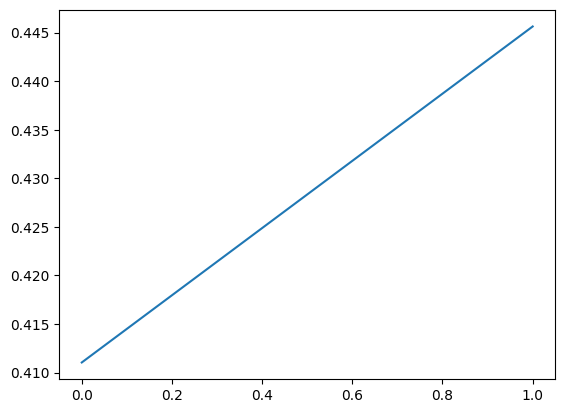

In [95]:
import matplotlib.pyplot as plt

model = BPR(train_R = train, test_R = test, d=15, epochs= 30000)

# Train the model
train_auc_list = model.fit()
plt.plot(train_auc_list)

AUC 계산 무슨 일,,,
# 이 코드의 문제는
1. AUC 계산이 매우 느리며
2. 논문에 의하면 0.8~0.9 사이의 값이 나와야 하는데 너무 작다.( 사실 이건 훈련을 너무 적게 시켜서인듯,, 꾸준히,,,, 하다보면 AUC 개선은 되는 중....)


# 사실 이러한 문제는
 AUC를 계산할 때 전체 user에 대해서 하지말고 그냥 gradient_descent할 때마다 xui -xuj 부호 체크해서 > 0이면 +1을 해주고, user도 sampling 된 user수로 나눠가지고 하면...... 그래도 좀 문제가 있다...


# 의문인 점

    def compute_AUC(self):
      X_hat = np.dot(self.W, self.H.T)
      auc = 0
      for u in range(self.num_user):
       pos_items = self.pos_items_dict[u]
        neg_items = self.neg_items_dict[u]
       for p in pos_items:
         for j in neg_items:
          if X_hat[u, p] > X_hat[u, j]:
            auc += 1

 여기의 어느 부분이 그렇게 속도가 오래 걸리지?? self.num_user도 943이고 아이템 수도 1682인데 (943 X 1682)... 연산이라고는 부등호와 덧셈뿐인데
  user마다 pos_items을 가져오는 과정이 오래 걸리남


=> Pytorch 버전으로 다시 짜보기 !!(+ KNN)